## Scaling estimates figure

In [7]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [23]:
sns.set_context('talk')
sns.set_style('white')

In [4]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [5]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh=97.5 # head depth
Hr = 132.0 # rim depth at DnS
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)



In [8]:
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 

records = canyon_records.main()


In [9]:
# records2 has all the runs without the ones where K_bg changes. I don't want to use this ones for fitting the data
ind = [0,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,20,21]
       
records2 = []
for ii in ind:
    records2.append(records[ii])


In [93]:
# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,21]
records3 = []
for ii in ind:
    records3.append(records[ii])

    # records4 has all the runs without Asc bott that has N below NaN, and Kv can runs
ind = [0,3,4,5,6,7,8,9,15,16,17,18,19,20,21,22,23,24,25,26,28]
records4 = []
for ii in ind:
    records4.append(records[ii])


In [12]:
select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]

for ind in select_rec:
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    
    #print(file)
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']

In [14]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['N2_tt08','N2_tt10','N2_tt12','N2_tt14','N2_tt16',]
key0 = 'N2_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N2_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    maxd3 = max(df_anom[keys[0]][26:])   # 22:26 for other scaling
    maxd4 = max(df_anom[keys[1]][26:])   
    maxd5 = max(df_anom[keys[2]][26:])   
    maxd6 = max(df_anom[keys[3]][26:])   
    maxd7 = max(df_anom[keys[4]][26:])   
    
    record.maxN = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.stdN = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
  
    maxd3a = max(df_anom[keys[0]][22:26])   # 22:26 for other scaling
    maxd4a = max(df_anom[keys[1]][22:26])   
    maxd5a = max(df_anom[keys[2]][22:26])   
    maxd6a = max(df_anom[keys[3]][22:26])   
    maxd7a = max(df_anom[keys[4]][22:26])   
    
    record.maxNabove = np.mean(np.array([maxd3a,maxd4a,maxd5a,maxd6a,maxd7a]))
    record.stdNabove = np.std(np.array([maxd3a,maxd4a,maxd5a,maxd6a,maxd7a]))
   # print(filename1)

In [15]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
 
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.inidTrdz = df[key0][30]
print('The initial tracer gradient is %f ' %(-1*record.inidTrdz))

The initial tracer gradient is 0.035983 


In [16]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:32])   
    maxd5 = np.mean(df[keys[1]][25:32])   
    maxd6 = np.mean(df[keys[2]][25:32]) 
    maxd7 = np.mean(df[keys[3]][25:32])  
    maxd8 = np.mean(df[keys[4]][25:32])  
    
     
    maxd0 = df[key0][29]
    
    
    record.maxTr = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.stdTr = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    
    
    record.TrSB = maxd0
Ctop = df[key0][0]

The rms error for N/No above is 0.058308
The rms error for N/N0 below is 0.551110
The rms error for dTr/dz above is 0.075279
The rms error for C/Co is 0.001531
The rms error for Phi is 0.986358
The rms error for PhiTr/1E5 above is 0.457913
-0.0359832763672


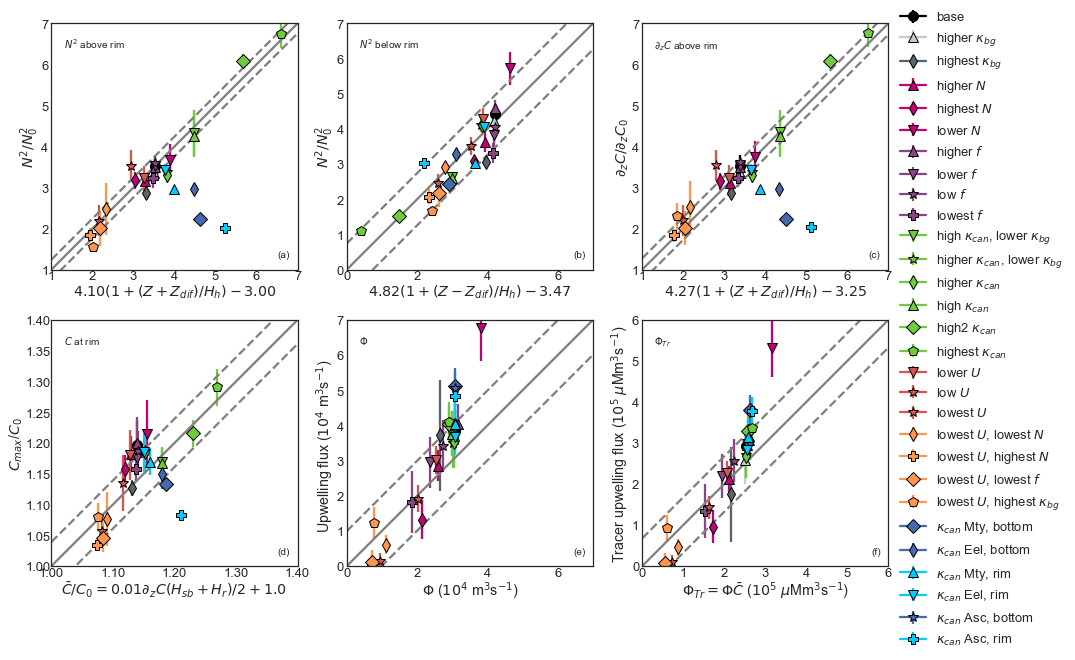

In [53]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (15,10)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[1,2])

t=6.5 # days

# Tr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records:
    
    Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg)) 
    
    rec.Z = Z
    rec.Zdif = Zdif
    
    plt1 = ax0.errorbar((4.10*(1+(Z+Zdif)/Hh))-3.00,rec.maxNabove/(rec.N**2),
                        yerr = rec.stdNabove/(rec.N**2), # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    
    ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
    ax0.set_xlabel(r'$4.10(1+(Z+Z_{dif})/H_h)-3.00$',labelpad=0.5)

maxN_array_Kv = np.array([rec.maxNabove/(rec.N**2) for rec in records2])
tilt_array_Kv = np.array([1+(rec.Z+rec.Zdif)/Hh for rec in records2])
x_fit = np.linspace(1.0, 7, 50)

mean_sq_err = np.mean(((maxN_array_Kv)-(4.10*tilt_array_Kv-3.00))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for N/No above is %f' %mean_sq_err)

ax0.plot(np.linspace(1.0, 7, 50),np.linspace(1.0, 7, 50),'-', color='0.5')
ax0.set_ylim(1,7)
ax0.set_xlim(1,7)

ax0.text(0.92,0.05,'(a)',transform=ax0.transAxes,fontsize=10)
ax0.text(0.05,0.9,'$N^2$ above rim',transform=ax0.transAxes,fontsize=10)
ax0.set_aspect(1)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No below %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

for rec in records:
    
    plt1 = ax1.errorbar((4.82*(1+(rec.Z-rec.Zdif)/Hh))-3.47,rec.maxN/(rec.N**2),
                        yerr = rec.stdN/(rec.N**2), # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    
    ax1.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
    ax1.set_xlabel(r'$4.82(1+(Z-Z_{dif})/H_h)-3.47$',labelpad=0.5)

maxN_array = np.array([rec.maxN/(rec.N**2) for rec in records2])
tilt_array = np.array([((rec.Z-rec.Zdif)/Hh) for rec in records2])
x_fit = np.linspace(0, 7, 50)

mean_sq_err = np.mean(((maxN_array_Kv)-(4.82*tilt_array_Kv-3.47))**2)

upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for N/N0 below is %f' %mean_sq_err)

ax1.plot(np.linspace(0, 7, 50),np.linspace(0, 7, 50),'-', color='0.5')
ax1.set_ylim(0,7)
ax1.set_xlim(0,7)
ax1.text(0.92,0.05,'(b)',transform=ax1.transAxes,fontsize=10)
ax1.text(0.05,0.9,'$N^2$ below rim',transform=ax1.transAxes,fontsize=10)
ax1.set_aspect(1)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.plot(np.linspace(1,7, 50),np.linspace(1,7, 50),'-', color='0.5')

for rec in records:
    
    plt1 = ax2.errorbar(4.17*(1+(rec.Z+rec.Zdif)/Hh)-3.25,rec.maxdTrdz/rec.inidTrdz,
                        yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
   
    ax2.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
    ax2.set_xlabel(r'$4.27(1+(Z+Z_{dif})/H_h)-3.25$',labelpad=0.5)

maxN_array = np.array([rec.maxdTrdz/rec.inidTrdz for rec in records2])
tilt_array = np.array([1+(rec.Z+rec.Zdif)/Hh for rec in records2])
x_fit = np.linspace(1,7, 50)

mean_sq_err = np.mean(((maxN_array)-(4.17*tilt_array-3.25))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

print('The rms error for dTr/dz above is %f' %mean_sq_err)

ax2.text(0.92,0.05,'(c)',transform=ax2.transAxes,fontsize=10)
ax2.text(0.05,0.9,'$\partial_zC$ above rim',transform=ax2.transAxes,fontsize=10)

ax2.set_ylim(1,7)
ax2.set_xlim(1,7)
ax2.set_aspect(1)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax3.plot(np.linspace(1,1.4, 50),np.linspace(1,1.4, 50),'-', color='0.5')

for rec in records:
     
    dTrdz = -rec.inidTrdz*(4.17*(1+(rec.Z+rec.Zdif)/Hh)-3.25)
    plt1 = ax3.errorbar((0.01*(dTrdz*(Hh+132.0)/2.0)) + 1.00,rec.maxTr/rec.TrSB,
                        yerr = rec.stdTr/rec.TrSB,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    rec.dTr = dTrdz
    #ax3.set_title('Max tracer concetration between head nad sh, Dn')
    ax3.set_ylabel('$C_{max}$/$C_{0}$',labelpad=0.5)
    ax3.set_xlabel(r'$\bar{C}/C_{0}=%1.2f\partial_zC(H_{sb}+H_r)/2+%1.1f$' %((0.01),(1.00)),labelpad=0.5)

fmt = FormatStrFormatter('%1.2f')
ax3.xaxis.set_major_formatter(fmt)
ax3.yaxis.set_major_formatter(fmt)

ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)

maxN_array = np.array([rec.maxTr/rec.TrSB for rec in records2])
tilt_array = np.array([(0.01*(rec.dTr*(Hh+132.0)/2.0))+1.00 for rec in records2])
x_fit = np.linspace(1,1.4, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for C/Co is %f' %mean_sq_err)

ax3.text(0.92,0.05,'(d)',transform=ax3.transAxes,fontsize=10)
ax3.text(0.05,0.9,'$C$ at rim',transform=ax3.transAxes,fontsize=10)

ax3.set_ylim(1,1.4)
ax3.set_xlim(1,1.4)
ax3.set_aspect(1)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec in records:
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    plt1 = ax4.errorbar(HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N))/1E4,Phi/1E4,
                        yerr=Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    rec.Phi = Phi
    rec.HA2013 = HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N))

ax4.set_ylabel(r'Upwelling flux ($10^4$ m$^3$s$^{-1}$)  ',labelpad=0.5)
ax4.set_xlabel(r'$\Phi$ ($10^4$ m$^3$s$^{-1}$)',labelpad=0.5)
    
maxN_array = np.array([rec.Phi/1E4 for rec in records3])
tilt_array = np.array([rec.HA2013/1E4 for rec in records3])
x_fit = np.linspace(0,7, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax4.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax4.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for Phi is %f' %mean_sq_err)

ax4.plot(np.linspace(0,7, 50),np.linspace(0,7, 50),'-', color='0.5')
ax4.text(0.92,0.05,'(e)',transform=ax4.transAxes,fontsize=10)
ax4.text(0.05,0.9,'$\Phi$',transform=ax4.transAxes,fontsize=10)
    
ax4.set_ylim(0,7)
ax4.set_xlim(0,7)
ax4.set_aspect(1)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec in records:    
    
    Capprox=rec.TrSB*((0.01*(rec.dTr*(Hh+132.0)/2.0))+1.0)
    
    mass_can_eff = rec.TrMass
    can_eff = rec.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    phiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    plt1 = ax5.errorbar(rec.HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                        (phiTr)/1E5,
                        yerr = phiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    rec.PhiTr = (phiTr)
    rec.PhiTrScale = rec.HA2013*(Capprox)
     
ax5.set_xlabel(r'$\Phi_{Tr}=\Phi \bar{C}$ ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)
ax5.set_ylabel(r'Tracer upwelling flux ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)

maxN_array = np.array([rec.PhiTr/1E5 for rec in records3])
tilt_array = np.array([rec.PhiTrScale/1E5 for rec in records3])
x_fit = np.linspace(0,6, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax5.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax5.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for PhiTr/1E5 above is %f' %mean_sq_err)

ax5.plot(np.linspace(0,6, 50),np.linspace(0,6, 50),'-', color='0.5')
ax5.text(0.93,0.05,'(f)',transform=ax5.transAxes,fontsize=10)
ax5.text(0.05,0.9,'$\Phi_{Tr}$',transform=ax5.transAxes,fontsize=10)

ax5.set_ylim(0,6)
ax5.set_xlim(0,6)
ax5.set_aspect(1)
    
ax5.legend(bbox_to_anchor=(1.0,2.3),ncol=1, columnspacing=0.1)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)
ax5.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)

#plt.savefig('figure9.eps',format='eps',bbox_inches='tight')

print(rec.inidTrdz)

### Using scaled N below rim in the $\Phi$ scaling

In [94]:
# Fit line to upwelling flux data

for rec in records:
    
    rec.N_sc = (((4.82*(1+(rec.Z-rec.Zdif)/Hh))-3.47)*(rec.N**2))**0.5
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    rec.Phi = Phi
    rec.Phi_std = Phi_std
    rec.HA2013 = HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N_sc))
    
phi_array = np.array([rec.Phi for rec in records4])
tilt_array = np.array([rec.HA2013 for rec in records4])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tilt_array,phi_array)

print(slope, intercept)

1.33753423831 10014.4473802


The rms error for C/Co is 0.001531
The rms error for Phi is 1.898694
The rms error for PhiTr/1E5 above is 2.011829
-0.0359832763672


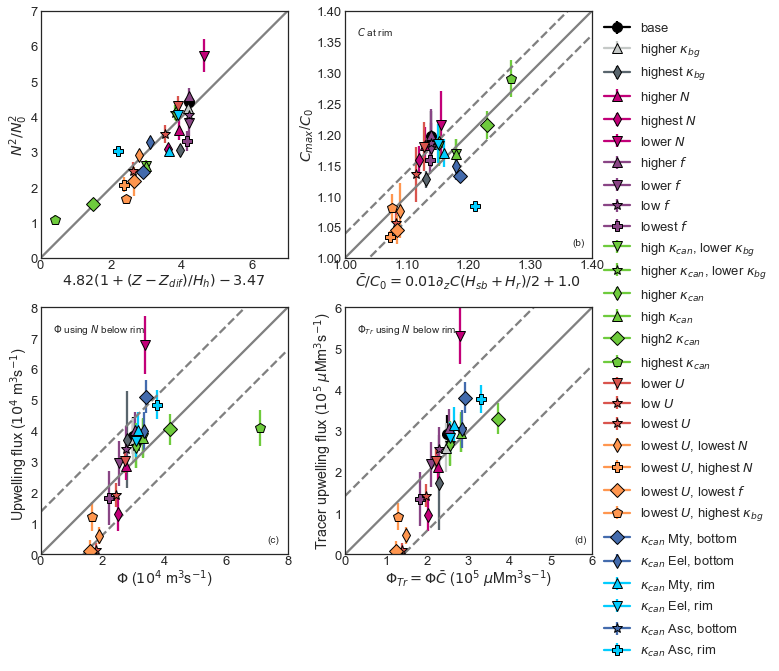

In [106]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,10)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])

t=6.5 # days

# Tr

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No below %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

for rec in records:
    
    plt1 = ax0.errorbar(rec.N_sc**2/(rec.N**2),rec.maxN/(rec.N**2),
                        yerr = rec.stdN/(rec.N**2), # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    
    ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
    ax0.set_xlabel(r'$4.82(1+(Z-Z_{dif})/H_h)-3.47$',labelpad=0.5)

ax0.plot(np.linspace(0, 7, 50),np.linspace(0, 7, 50),'-', color='0.5')
ax0.set_ylim(0,7)
ax0.set_xlim(0,7)
ax0.text(0.92,0.05,'(a)',transform=ax1.transAxes,fontsize=10)
ax0.text(0.05,0.9,'$N^2$ below rim',transform=ax1.transAxes,fontsize=10)
ax0.set_aspect(1)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax1.plot(np.linspace(1,1.4, 50),np.linspace(1,1.4, 50),'-', color='0.5')

for rec in records:
     
    dTrdz = -rec.inidTrdz*(4.17*(1+(rec.Z+rec.Zdif)/Hh)-3.25)
    plt1 = ax1.errorbar((0.01*(dTrdz*(Hh+132.0)/2.0)) + 1.00,rec.maxTr/rec.TrSB,
                        yerr = rec.stdTr/rec.TrSB,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    rec.dTr = dTrdz
    #ax3.set_title('Max tracer concetration between head nad sh, Dn')
    ax1.set_ylabel('$C_{max}$/$C_{0}$',labelpad=0.5)
    ax1.set_xlabel(r'$\bar{C}/C_{0}=%1.2f\partial_zC(H_{sb}+H_r)/2+%1.1f$' %((0.01),(1.00)),labelpad=0.5)

fmt = FormatStrFormatter('%1.2f')
ax1.xaxis.set_major_formatter(fmt)
ax1.yaxis.set_major_formatter(fmt)

ax1.tick_params(axis='x', pad=1)
ax1.tick_params(axis='y', pad=1)

maxN_array = np.array([rec.maxTr/rec.TrSB for rec in records2])
tilt_array = np.array([(0.01*(rec.dTr*(Hh+132.0)/2.0))+1.00 for rec in records2])
x_fit = np.linspace(1,1.4, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for C/Co is %f' %mean_sq_err)

ax1.text(0.92,0.05,'(b)',transform=ax1.transAxes,fontsize=10)
ax1.text(0.05,0.9,'$C$ at rim',transform=ax1.transAxes,fontsize=10)

ax1.set_ylim(1,1.4)
ax1.set_xlim(1,1.4)
ax1.set_aspect(1)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec in records:
    
    plt1 = ax2.errorbar(((slope*rec.HA2013)+intercept)/1E4,rec.Phi/1E4,
                        yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    
ax2.set_ylabel(r'Upwelling flux ($10^4$ m$^3$s$^{-1}$)  ',labelpad=0.5)
ax2.set_xlabel(r'$\Phi$ ($10^4$ m$^3$s$^{-1}$)',labelpad=0.5)
    
maxN_array = np.array([rec.Phi/1E4 for rec in records4])
tilt_array = np.array([((slope*rec.HA2013)+intercept)/1E4 for rec in records4])
x_fit = np.linspace(0,8, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for Phi is %f' %mean_sq_err)

ax2.plot(np.linspace(0,8, 50),np.linspace(0,8, 50),'-', color='0.5')
ax2.text(0.92,0.05,'(c)',transform=ax2.transAxes,fontsize=10)
ax2.text(0.05,0.9,'$\Phi$ using $N$ below rim',transform=ax2.transAxes,fontsize=10)
    
ax2.set_ylim(0,8)
ax2.set_xlim(0,8)
ax2.set_aspect(1)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec in records:    
    
    Capprox=rec.TrSB*((0.01*(rec.dTr*(Hh+132.0)/2.0))+1.0)
    
    mass_can_eff = rec.TrMass
    can_eff = rec.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    phiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    plt1 = ax3.errorbar((slope*rec.HA2013+intercept)*(Capprox)/1E5, # 1000 is a conversion factor
                        (phiTr)/1E5,
                        yerr = phiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label)
    rec.PhiTr = (phiTr)
    rec.PhiTrScale = rec.HA2013*(Capprox)
     
ax3.set_xlabel(r'$\Phi_{Tr}=\Phi \bar{C}$ ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)
ax3.set_ylabel(r'Tracer upwelling flux ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)

maxN_array = np.array([rec.PhiTr/1E5 for rec in records3])
tilt_array = np.array([rec.PhiTrScale/1E5 for rec in records3])
x_fit = np.linspace(0,6, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for PhiTr/1E5 above is %f' %mean_sq_err)

ax3.plot(np.linspace(0,6, 50),np.linspace(0,6, 50),'-', color='0.5')
ax3.text(0.93,0.05,'(d)',transform=ax3.transAxes,fontsize=10)
ax3.text(0.05,0.9,'$\Phi_{Tr}$ using $N$ below rim',transform=ax3.transAxes,fontsize=10)

ax3.set_ylim(0,6)
ax3.set_xlim(0,6)
ax3.set_aspect(1)
    
ax1.legend(bbox_to_anchor=(1.0,1),ncol=1, columnspacing=0.1)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax3.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax3.tick_params(axis='y', pad=3)

#plt.savefig('figure9.eps',format='eps',bbox_inches='tight')

print(rec.inidTrdz)